In [9]:
# Probabilistic Fault Seal: P10/P50/P90 Column Height (Synthetic Demo)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# ----------------------------
# 1. Simple column height model (empirical scaling)
# ----------------------------
def column_height_from_sgr(sgr, scale=100.0):
    """Convert SGR (0–1) to max column height in meters."""
    return np.clip(sgr * scale, 0, None)

# ----------------------------
# 2. Generate synthetic training data
# ----------------------------
np.random.seed(2026)
n = 200
net_shale = np.random.uniform(0.2, 0.9, n)      # fraction of shale
throw = np.random.uniform(20, 200, n)           # fault throw in meters

# SGR increases with shale content and throw (geologically intuitive)
sgr_true = 0.2 + 0.7 * net_shale + 0.001 * throw + np.random.normal(0, 0.06, n)
sgr_true = np.clip(sgr_true, 0.1, 0.95)

X = np.column_stack((net_shale, throw))

# ----------------------------
# 3. Train quantile regression models
# ----------------------------
def fit_quantile_rf(X, y, q):
    """Train a quantile Random Forest using sample weighting."""
    rf = RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=42)
    weights = np.where(y >= np.median(y), q, 1 - q)
    rf.fit(X, y, sample_weight=weights)
    return rf

rf_p10 = fit_quantile_rf(X, sgr_true, 0.10)
rf_p50 = fit_quantile_rf(X, sgr_true, 0.50)
rf_p90 = fit_quantile_rf(X, sgr_true, 0.90)

# ----------------------------
# 4. Predict for a new fault location
# ----------------------------
X_new = np.array([[0.60, 80]])  # net shale = 60%, throw = 80 m

# Extract scalar predictions (fixes deprecation warning)
sgr_p10 = rf_p10.predict(X_new)[0]
sgr_p50 = rf_p50.predict(X_new)[0]
sgr_p90 = rf_p90.predict(X_new)[0]

# Ensure valid SGR range
sgr_p10 = np.clip(sgr_p10, 0.01, 1.0)
sgr_p50 = np.clip(sgr_p50, 0.01, 1.0)
sgr_p90 = np.clip(sgr_p90, 0.01, 1.0)

# ----------------------------
# 5. Compute P10/P50/P90 column heights
# ----------------------------
H_p10 = column_height_from_sgr(sgr_p10)  # weakest plausible seal
H_p50 = column_height_from_sgr(sgr_p50)
H_p90 = column_height_from_sgr(sgr_p90)  # strongest plausible seal

print(f"P10 Column Height: {H_p10:.1f} m")
print(f"P50 Column Height: {H_p50:.1f} m")
print(f"P90 Column Height: {H_p90:.1f} m")

P10 Column Height: 64.5 m
P50 Column Height: 67.8 m
P90 Column Height: 71.2 m


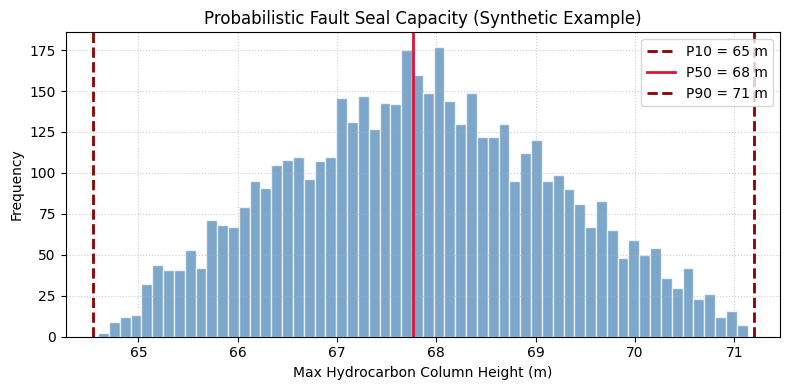

In [11]:
# Monte Carlo sampling between P10–P90
sgr_samples = np.random.triangular(sgr_p10, sgr_p50, sgr_p90, 5000)
H_samples = column_height_from_sgr(sgr_samples)

plt.figure(figsize=(8, 4))
plt.hist(H_samples, bins=60, color='steelblue', alpha=0.7, edgecolor='white')
plt.axvline(H_p10, color='darkred', ls='--', lw=2, label=f'P10 = {H_p10:.0f} m')
plt.axvline(H_p50, color='crimson', ls='-',  lw=2, label=f'P50 = {H_p50:.0f} m')
plt.axvline(H_p90, color='darkred', ls='--', lw=2, label=f'P90 = {H_p90:.0f} m')
plt.xlabel('Max Hydrocarbon Column Height (m)')
plt.ylabel('Frequency')
plt.title('Probabilistic Fault Seal Capacity (Synthetic Example)')
plt.legend()
plt.grid(True, ls=':', alpha=0.6)
plt.tight_layout()
plt.show()